In [3]:
import h5py
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.externals import joblib
import pickle
import argparse
import os

DATA_DIR = '/bigdata/shared/analysis/H5CR/OR_CUT/MultiJet/'
BACKGROUND = ['DYJets','Other','QCD','SingleTop','TTJets','WJets','ZInv']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Divide 1L control region dataset into ttbar enhanced and W+jets enhanced region where:
1. ttbar enhanced: at least 1 b-tag
2. wjet enhanced: 0 b-tag

In [4]:
from training import to_regular_array

def split_dataset(dataset):
    np.random.shuffle(dataset)
    train_index = int(0.6 * dataset.shape[0])
    val_index = int(train_index*4/3)
    training_set = dataset[:train_index]
    val_set = dataset[train_index:val_index]
    test_set = dataset[val_index:]
    return training_set, val_set, test_set   

def remove_outlier(arr):
    # Will remove outlier according to each feature.
    def clip(arr, lower, sub_lower, upper, sub_upper):
        arr[arr < lower] = float(sub_lower)
        arr[arr > upper] = float(sub_upper)
        return arr

    arr['alphaT'] = clip(arr['alphaT'], 0, 0, 100, 100)
    arr['dPhiMinJetMET'] = clip(arr['dPhiMinJetMET'], -np.pi, 0, np.pi, 0)
    arr['dPhiRazor'] = clip(arr['dPhiRazor'], -np.pi, 0, np.pi, 0)
    arr['HT'] = clip(arr['HT'], 0, 0, 10000, 10000)
    arr['jet1MT'] = clip(arr['jet1MT'], 0, 0, 10000, 10000)
    arr['leadingJetCISV'] = clip(arr['leadingJetCISV'], 0, 0, 1, 1)
    arr['leadingJetPt'] = clip(arr['leadingJetPt'], 0, 0, 5000, 5000)
    arr['MET'] = clip(arr['MET'], 0, 0, 5000, 5000)
    arr['MHT'] = clip(arr['MHT'], 0, 0, 5000, 5000)
    arr['MR'] = clip(arr['MR'], 0, 0, 10000, 10000)
    arr['MT2'] = clip(arr['MT2'], 0, 0, 5000, 5000)
    arr['nSelectedJets'] = clip(arr['nSelectedJets'], 0, 0, 20, 20)
    arr['Rsq'] = clip(arr['Rsq'], 0, 0, 5, 5)
    arr['subleadingJetPt'] = clip(arr['subleadingJetPt'], 0, 0, 4000, 4000)

    return arr

for i,bkg in enumerate(BACKGROUND):
    _file = h5py.File(DATA_DIR+'/'+bkg+'.h5','r')
    _background = to_regular_array(remove_outlier(_file['Data'][:]))
    if i == 0: Background = np.copy(_background)
    else: Background = np.vstack((Background, _background))
for i,sn in enumerate(SIGNAL):
    _file = h5py.File(DATA_DIR+'/'+sn+'.h5','r')
    _signal = to_regular_array(remove_outlier(_file['Data'][:]))
    if i == 0: Signal = np.copy(_signal)
    else: Signal = np.vstack((Signal, _signal))    
        

from training import clean_dataset
Signal = clean_dataset(Signal)
Background = clean_dataset(Background)
train_bkg, val_bkg, test_bkg = split_dataset(Background)
train_sn, val_sn, test_sn = split_dataset(Signal)

train_weight = float(train_sn.shape[0])/float(train_bkg.shape[0])
val_weight = float(val_sn.shape[0])/float(val_bkg.shape[0])

def random_frac(arr, fraction, label = ''):
    print("Getting a fraction of {} from {}".format(fraction,label))
    print("- Initial shape: ")
    print arr.shape
    sample_size = int(fraction*arr.shape[0])
    print("- Sampling {} entries".format(sample_size))
    idx = np.random.randint(arr.shape[0],size=sample_size)
    out = arr[idx,:]
    print("- Output shape: ")
    print out.shape
    return out


train_bkg = random_frac(train_bkg, train_weight, "Training Background")
val_bkg = random_frac(val_bkg, train_weight, "Validation Background")

with h5py.File(DATA_DIR+"/Parameterized_Dataset.h5",'w') as outfile:
    print train_sn.shape
    print train_bkg.shape
    train_dataset = np.vstack((train_sn, train_bkg))
    val_dataset = np.vstack((val_sn, val_bkg))
    #test_dataset = np.vstack((test_sn, test_bkg))
    test_dataset = np.vstack((Signal,test_bkg)) # avoid the sparsity problem
    print "Finished stacking"
    outfile.create_dataset("Training", data=train_dataset)
    outfile.create_dataset("Validation", data=val_dataset)
    outfile.create_dataset("Test",data=test_dataset)

Before cleaning: (520351, 18)
After cleaning: (520347, 18)
Before cleaning: (35014076, 18)
After cleaning: (35013935, 18)
Getting a fraction of 0.014861130766 from Training Background
- Initial shape: 
(21008361, 18)
- Sampling 312208 entries
- Output shape: 
(312208, 18)
Getting a fraction of 0.014861130766 from Validation Background
- Initial shape: 
(7002787, 18)
- Sampling 104069 entries
- Output shape: 
(104069, 18)
(312208, 18)
(312208, 18)
Finished stacking


For training and validation, need to have equal number of signal and background. For test set, keep the original to avoid repeated predictions.

In [77]:
def multiply_data(data, multiplicity):
    print ("Dataset size before multiplied by {}: {}".format(multiplicity,data.shape[0]))
    for i in range(multiplicity):
        if i==0: sum_data = np.copy(data)
        else: sum_data = np.vstack((sum_data, data))
    print ("Dataset size after multiplicity: {}".format(sum_data.shape[0]))
    return sum_data


Getting a fraction of 1.0 from train bkg
- Initial shape: 
(8859, 16)
- Sampling 8859 entries
- Output shape: 
(8859, 16)
Getting a fraction of 1.0 from val bkg
- Initial shape: 
(10325265, 16)
- Sampling 10325265 entries
- Output shape: 
(10325265, 16)
(8859, 16)
(8859, 16)


38055554.1844


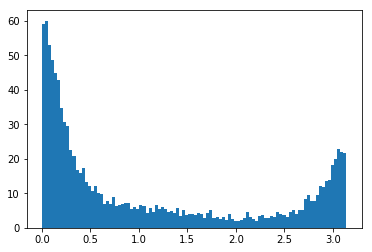

In [18]:
data = Background[:,2:]
weight = Background[:,1]
label = Background[:,0]
data_bkg = data[label < 0.5]
weight_bkg = weight[label < 0.5]
n, _, _ = plt.hist(data_bkg[:,1], weights=weight_bkg, bins=100)
print sum(n)*35900

38055577.4056


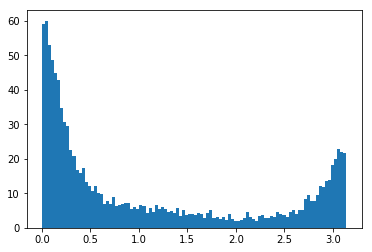

In [20]:
DATA_DIR = '/bigdata/shared/analysis/'
for i,bkg in enumerate(BACKGROUND):
    _file = h5py.File(DATA_DIR+'/'+bkg+'.h5','r')
    _background = to_regular_array(remove_outlier(_file['Data'][:]))
    if i == 0: Background1 = np.copy(_background)
    else: Background1 = np.vstack((Background1, _background))
data = Background1[:,2:]
weight = Background1[:,1]
label = Background1[:,0]
data_bkg = data[label < 0.5]
weight_bkg = weight[label < 0.5]
n, _, _ = plt.hist(data_bkg[:,1], weights=weight_bkg, bins=100)
print sum(n)*35900

In [32]:
from training import to_regular_array
def remove_outlier(arr):
    # Will remove outlier according to each feature.
    def clip(arr, lower, sub_lower, upper, sub_upper):
        arr[arr < lower] = float(sub_lower)
        arr[arr > upper] = float(sub_upper)
        return arr

    arr['alphaT'] = clip(arr['alphaT'], 0, 0, 100, 100)
    arr['dPhiMinJetMET'] = clip(arr['dPhiMinJetMET'], -np.pi, 0, np.pi, 0)
    arr['dPhiRazor'] = clip(arr['dPhiRazor'], -np.pi, 0, np.pi, 0)
    arr['HT'] = clip(arr['HT'], 0, 0, 10000, 10000)
    arr['jet1MT'] = clip(arr['jet1MT'], 0, 0, 10000, 10000)
    arr['leadingJetCISV'] = clip(arr['leadingJetCISV'], 0, 0, 1, 1)
    arr['leadingJetPt'] = clip(arr['leadingJetPt'], 0, 0, 5000, 5000)
    arr['MET'] = clip(arr['MET'], 0, 0, 5000, 5000)
    arr['MHT'] = clip(arr['MHT'], 0, 0, 5000, 5000)
    arr['MR'] = clip(arr['MR'], 0, 0, 10000, 10000)
    arr['MT2'] = clip(arr['MT2'], 0, 0, 5000, 5000)
    arr['nSelectedJets'] = clip(arr['nSelectedJets'], 0, 0, 20, 20)
    arr['Rsq'] = clip(arr['Rsq'], 0, 0, 5, 5)
    arr['subleadingJetPt'] = clip(arr['subleadingJetPt'], 0, 0, 4000, 4000)

    return arr
_qcd = h5py.File(DATA_DIR+'/QCD.h5','r')
QCD = to_regular_array(remove_outlier(_qcd['Data'][:]))
#print QCD[342]
qcd = np.asarray(QCD[:,1])

(array([  6.40940000e+04,   4.71150000e+04,   3.68630000e+04,
          9.21640000e+04,   4.34836000e+05,   1.47778000e+05,
          1.16670000e+04,   1.48300000e+04,   1.73060000e+04,
          6.07100000e+04,   3.03481000e+05,   5.61720000e+04,
          5.95160000e+04,   7.56370000e+04,   1.30600000e+04,
          7.24600000e+03,   4.17600000e+03,   2.65800000e+03,
          4.33000000e+02,   1.34000000e+02,   1.24000000e+02,
          7.46000000e+02,   1.46000000e+03,   5.41000000e+03,
          1.45520000e+04,   7.70000000e+02,   3.25000000e+02,
          1.70000000e+02,   3.41000000e+02,   2.21000000e+02,
          1.06700000e+03,   2.59600000e+03,   1.22200000e+03,
          3.67500000e+03,   7.29000000e+02,   5.78000000e+02,
          1.05500000e+03,   5.63300000e+03,   2.51700000e+03,
          1.41100000e+03,   6.38000000e+02,   3.84000000e+02,
          2.31500000e+03,   5.17000000e+02,   3.16400000e+03,
          1.53500000e+03,   1.16300000e+03,   2.75600000e+03,
        

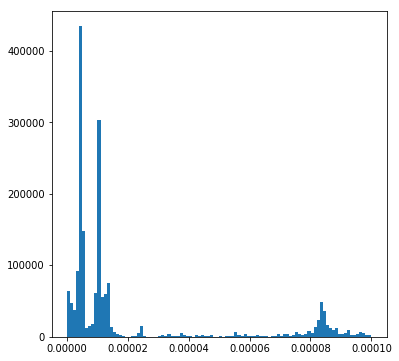

In [35]:
plt.figure(figsize=(6,6))
plt.hist(qcd,bins=100,range=[1e-7, 1e-4])